<a href="https://colab.research.google.com/github/Sreemourya710/Assignment2/blob/main/Assgnmt2_AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium==0.27.1 -q
!pip install gymnasium[box2d] -q
!pip install moviepy -q
!pip install -U kora -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce this behaviour change. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368
  

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/HW2AC
!ls

Mounted at /content/drive
/content/drive/MyDrive/HW2AC


In [3]:
import random
import numpy as np
import torch.cuda


def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)


def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'


# Util function to apply reward-discounting scheme on a list of instant-reward (from eq 8 of HW1)
def apply_discount(raw_reward, gamma=0.99):
    # TODO(DONE): Compute discounted_rtg_reward (as a list) from raw_reward
    # HINT: Reverse the input list, keep a running-average. Reverse again to get the correct order.
    discounted_rtg_reward = []
    discounted_reward = 0
    for r in reversed(raw_reward):
        # print(type(r), r)
        discounted_reward = r + discounted_reward * gamma
        discounted_rtg_reward.append(discounted_reward)
    discounted_rtg_reward = list(reversed(discounted_rtg_reward))

    # Normalization
    # print(type(discounted_rtg_reward))
    discounted_rtg_reward = np.array(discounted_rtg_reward)

    discounted_rtg_reward = discounted_rtg_reward - np.mean(discounted_rtg_reward) / (np.std(discounted_rtg_reward) + np.finfo(np.float32).eps)
    return torch.tensor(discounted_rtg_reward, dtype=torch.float32, device=get_device())

In [4]:
import copy
import pickle
import random
import gymnasium as gym
import torch
from collections import deque, namedtuple
from gymnasium.utils.save_video import save_video
from torch import nn
from torch.optim import Adam
from torch.distributions import Categorical

# Class for training an RL agent with Actor-Critic
class ACTrainer:
    def __init__(self, params):
        self.params = params
        self.env = gym.make(self.params['env_name'])
        self.agent = ACAgent(env=self.env, params=self.params)
        self.actor_net = ActorNet(input_size=self.env.observation_space.shape[0], output_size=self.env.action_space.n, hidden_dim=self.params['hidden_dim']).to(get_device())
        self.critic_net = CriticNet(input_size=self.env.observation_space.shape[0], output_size=1, hidden_dim=self.params['hidden_dim']).to(get_device())
        self.actor_optimizer = Adam(params=self.actor_net.parameters(), lr=self.params['actor_lr'])
        self.critic_optimizer = Adam(params=self.critic_net.parameters(), lr=self.params['critic_lr'])
        self.trajectory = None

    def run_training_loop(self):
        list_ro_reward = list()
        for ro_idx in range(self.params['n_rollout']):
            self.trajectory = self.agent.collect_trajectory(policy=self.actor_net)
            self.update_critic_net()
            self.estimate_advantage()
            self.update_actor_net()
            # TODO: Calculate avg reward for this rollout
            avg_ro_reward = abs(sum([sum(traj) for traj in self.trajectory['reward']]) / self.params['n_trajectory_per_rollout'])
            print(f'End of rollout {ro_idx}: Average trajectory reward is {avg_ro_reward: 0.2f}')
            # Append average rollout reward into a list
            list_ro_reward.append(avg_ro_reward)
        # Save avg-rewards as pickle files
        pkl_file_name = self.params['exp_name'] + '.pkl'
        with open(pkl_file_name, 'wb') as f:
            pickle.dump(list_ro_reward, f)
        # Save a video of the trained agent playing
        self.generate_video()
        # Close environment
        self.env.close()

    def update_critic_net(self):
        for critic_iter_idx in range(self.params['n_critic_iter']):
            self.update_target_value()
            for critic_epoch_idx in range(self.params['n_critic_epoch']):
                critic_loss = self.estimate_critic_loss_function()
                # critic_loss.backward()
                self.critic_optimizer.step()
                self.critic_optimizer.zero_grad()

    def update_target_value(self, gamma=0.99):
        # TODO: Changed This
        next_state_value = self.critic_net(torch.cat(self.trajectory['log_prob'])).detach().numpy()

        target_values = self.trajectory['reward'] + [gamma * next_state_value] * len(self.trajectory['reward'])

        self.trajectory['target_value'] = torch.cat([torch.FloatTensor(i) for i in target_values])

        # TODO: Changed This
        state_values = self.critic_net(torch.cat(self.trajectory['obs']))
        self.trajectory['state_value'] = state_values

    def estimate_advantage(self, gamma=0.99):
        # Compute target Q-value for each state-action pair
        rewards = torch.tensor(self.trajectory['reward'][0], dtype=torch.float)
        next_state_values = torch.tensor(self.trajectory['target_value'][:105], dtype=torch.float)
        target_q_values = rewards + gamma * next_state_values

        # Compute state-value estimate for each state
        state_values = torch.tensor(self.trajectory['state_value'], dtype=torch.float)

        # Compute advantage estimate for each state-action pair
        advantage_estimate = target_q_values - state_values
        self.trajectory['advantage'] = advantage_estimate.tolist()

    def update_actor_net(self):
        actor_loss = self.estimate_actor_loss_function()
        # actor_loss.backward()
        self.actor_optimizer.step()
        self.actor_optimizer.zero_grad()

    def estimate_critic_loss_function(self):
        critic_loss = torch.nn.functional.mse_loss(self.trajectory['state_value'], self.trajectory['target_value'])
        return critic_loss

    def estimate_actor_loss_function(self):
        actor_loss = list()
        for t_idx in range(self.params['n_trajectory_per_rollout']):
            try:
                advantage = apply_discount(self.trajectory['advantage'][t_idx])
            except:
                break
            actor_loss.append(torch.tensor(advantage))
        actor_loss = torch.cat([torch.tensor(t, requires_grad=True) for t in actor_loss])
        return actor_loss

    def generate_video(self, max_frame=1000):
        self.env = gym.make(self.params['env_name'], render_mode='rgb_array_list')
        obs, _ = self.env.reset()
        for _ in range(max_frame):
            action_idx, log_prob = self.actor_net(torch.tensor(obs, dtype=torch.float32, device=get_device()))
            obs, reward, terminated, truncated, info = self.env.step(self.agent.action_space[action_idx.item()])
            if terminated or truncated:
                break
        save_video(frames=self.env.render(), video_folder=self.params['env_name'][:-3], fps=self.env.metadata['render_fps'], step_starting_index=0, episode_index=0)


# CLass for actor-net
class ActorNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim):
        super(ActorNet, self).__init__()
        self.ff_net = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, obs):
        logits = self.ff_net(obs)
        dist = Categorical(logits=logits)
        action_index = dist.sample()
        log_prob = dist.log_prob(action_index)
        return action_index, log_prob


# CLass for actor-net
class CriticNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim):
        super(CriticNet, self).__init__()
        self.ff_net = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_size)
        )

    def forward(self, obs):
        state_value = self.ff_net(obs[:8])
        return state_value


# Class for agent
class ACAgent:
    def __init__(self, env, params=None):
        self.env = env
        self.params = params
        self.action_space = [action for action in range(self.env.action_space.n)]

    def collect_trajectory(self, policy):
        obs, _ = self.env.reset(seed=self.params['rng_seed'])
        rollout_buffer = list()
        for _ in range(self.params['n_trajectory_per_rollout']):
            trajectory_buffer = {'obs': list(), 'log_prob': list(), 'reward': list()}
            while True:
                obs = torch.tensor(obs, dtype=torch.float32, device=get_device())
                # Save observation
                trajectory_buffer['obs'].append(obs)
                action_idx, log_prob = policy(obs)
                obs, reward, terminated, truncated, info = self.env.step(self.action_space[action_idx.item()])
                # Save log-prob and reward into the buffer
                trajectory_buffer['log_prob'].append(log_prob)
                trajectory_buffer['reward'].append(reward)
                # Check for termination criteria
                if terminated or truncated:
                    obs, _ = self.env.reset()
                    rollout_buffer.append(trajectory_buffer)
                    break
        rollout_buffer = self.serialize_trajectory(rollout_buffer)
        return rollout_buffer

    # Converts a list-of-dictionary into dictionary-of-list
    @staticmethod
    def serialize_trajectory(rollout_buffer):
        serialized_buffer = {'obs': list(), 'log_prob': list(), 'reward': list()}
        for trajectory_buffer in rollout_buffer:
            serialized_buffer['obs'].append(torch.stack(trajectory_buffer['obs']))
            serialized_buffer['log_prob'].append(torch.stack(trajectory_buffer['log_prob']))
            if len(trajectory_buffer['reward']) < 105:
                trajectory_buffer['reward'].extend([0] * (105 - len(trajectory_buffer['reward'])))
            else:
                trajectory_buffer['reward'] = trajectory_buffer['reward'][:105]
            serialized_buffer['reward'].append(trajectory_buffer['reward'])
        return serialized_buffer

In [6]:
params_list = [{
    'env_name': 'LunarLander-v2',
    'rng_seed': 6369,
    'n_rollout': 100,
    'n_trajectory_per_rollout': 60,
    'n_critic_iter': 20,
    'n_critic_epoch': 20,
    'hidden_dim': 128,
    'actor_lr': 3e-3,
    'critic_lr': 3e-4,
    'exp_name': 'LunarLander_v2_t2'
},
{
    'env_name': 'LunarLander-v2',
    'rng_seed': 6369,
    'n_rollout': 100,
    'n_trajectory_per_rollout': 60,
    'n_critic_iter': 10,
    'n_critic_epoch': 10,
    'hidden_dim': 128,
    'actor_lr': 3e-3,
    'critic_lr': 3e-4,
    'exp_name': 'LunarLander_v2_t1'
},

{
    'env_name': 'LunarLander-v2',
    'rng_seed': 6369,
    'n_rollout': 100,
    'n_trajectory_per_rollout': 60,
    'n_critic_iter': 1,
    'n_critic_epoch': 1,
    'hidden_dim': 128,
    'actor_lr': 3e-3,
    'critic_lr': 3e-4,
    'exp_name': 'LunarLander_v2_t0'
},
]

# Train agent with each set of parameters
for params in params_list:
    # Seed RNGs
    seed_everything(params['rng_seed'])
# Train agent
    trainer = ACTrainer(params)
    trainer.run_training_loop()

<ipython-input-4-55dc71c77e29>:86: UserWarning: Using a target size (torch.Size([6360])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = torch.nn.functional.mse_loss(self.trajectory['state_value'], self.trajectory['target_value'])
<ipython-input-4-55dc71c77e29>:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state_values = torch.tensor(self.trajectory['target_value'][:105], dtype=torch.float)
<ipython-input-4-55dc71c77e29>:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_values = torch.tensor(self.trajectory['state_value'], dtype=torch.float)
<ipy

End of rollout 0: Average trajectory reward is  138.06
End of rollout 1: Average trajectory reward is  169.23
End of rollout 2: Average trajectory reward is  151.98
End of rollout 3: Average trajectory reward is  167.16
End of rollout 4: Average trajectory reward is  160.81
End of rollout 5: Average trajectory reward is  134.32
End of rollout 6: Average trajectory reward is  168.19
End of rollout 7: Average trajectory reward is  158.80
End of rollout 8: Average trajectory reward is  126.74
End of rollout 9: Average trajectory reward is  131.66
End of rollout 10: Average trajectory reward is  131.72
End of rollout 11: Average trajectory reward is  155.62
End of rollout 12: Average trajectory reward is  122.89
End of rollout 13: Average trajectory reward is  170.04
End of rollout 14: Average trajectory reward is  157.62
End of rollout 15: Average trajectory reward is  139.46
End of rollout 16: Average trajectory reward is  130.68
End of rollout 17: Average trajectory reward is  147.86
En

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/HW2AC/LunarLander/rl-video-episode-0.mp4
End of rollout 0: Average trajectory reward is  138.06
End of rollout 1: Average trajectory reward is  169.23
End of rollout 2: Average trajectory reward is  151.98
End of rollout 3: Average trajectory reward is  167.16
End of rollout 4: Average trajectory reward is  160.81
End of rollout 5: Average trajectory reward is  134.32
End of rollout 6: Average trajectory reward is  168.19
End of rollout 7: Average trajectory reward is  158.80
End of rollout 8: Average trajectory reward is  126.74
End of rollout 9: Average trajectory reward is  131.66
End of rollout 10: Average trajectory reward is  131.72
End of rollout 11: Average trajectory reward is  155.62
End of rollout 12: Average trajectory reward is  122.89
End of rollout 13: Average trajectory reward is  170.04
End of rollout 14: Average trajectory reward is  157.62
End of rollout 15: Average trajectory reward is  139.46
End of roll

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/HW2AC/LunarLander/rl-video-episode-0.mp4
End of rollout 0: Average trajectory reward is  138.06
End of rollout 1: Average trajectory reward is  169.23
End of rollout 2: Average trajectory reward is  151.98
End of rollout 3: Average trajectory reward is  167.16
End of rollout 4: Average trajectory reward is  160.81
End of rollout 5: Average trajectory reward is  134.32
End of rollout 6: Average trajectory reward is  168.19
End of rollout 7: Average trajectory reward is  158.80
End of rollout 8: Average trajectory reward is  126.74
End of rollout 9: Average trajectory reward is  131.66
End of rollout 10: Average trajectory reward is  131.72
End of rollout 11: Average trajectory reward is  155.62
End of rollout 12: Average trajectory reward is  122.89
End of rollout 13: Average trajectory reward is  170.04
End of rollout 14: Average trajectory reward is  157.62
End of rollout 15: Average trajectory reward is  139.46
End of roll

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/HW2AC/LunarLander/rl-video-episode-0.mp4


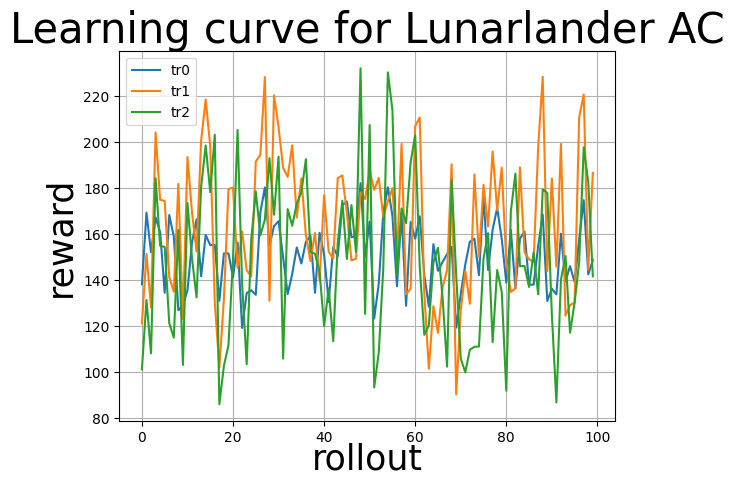

In [9]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

file_name0 = 'LunarLander_v2_t0' + '.pkl'
file_name1 = 'LunarLander_v2_t1' + '.pkl'
file_name2 = 'LunarLander_v2_t2' + '.pkl'

with open(file_name0, 'rb') as f:
    ro_reward0 = pickle.load(f)

with open(file_name1, 'rb') as f:
    ro_reward1 = pickle.load(f)

with open(file_name2, 'rb') as f:
    ro_reward2 = pickle.load(f)

# Plot the data
sns.lineplot(data=ro_reward0, linestyle='-', label='tr0')
sns.lineplot(data=ro_reward1, linestyle='-', label='tr1')
sns.lineplot(data=ro_reward2, linestyle='-', label='tr2')
plt.xlabel('rollout', fontsize=25, labelpad=-2)
plt.ylabel('reward', fontsize=25)
plt.title('Learning curve for Lunarlander AC', fontsize=30)
plt.legend()
plt.grid()
plt.show()

SreeMourya Ravirala
1002029130